# USING CLOSED LOOP DESIGNER

This notebook contains a case study of using SISOClosedLoopDesigner


In [1]:
import controlSBML as ctl
from controlSBML import constants as cn
from controlSBML import util

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sympy
ctl.__version__

'1.0.11'

In [2]:
TIMES = np.linspace(0, 20, 200)

# Models

## Linear

In [3]:
LINEAR_MDL = """
species S3

 -> S1; k0
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 0
S2 = 0
S3 = 0
k0 = 0
k1 = 1
k2 = 2
k3 = 3
"""

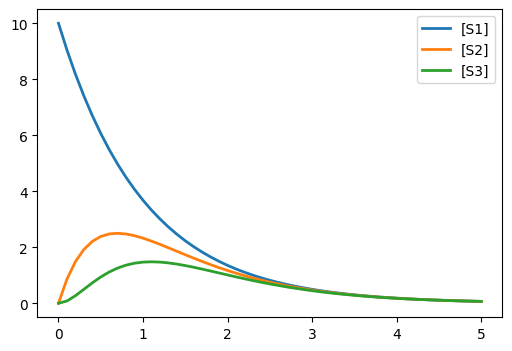

In [4]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = LINEAR_CTLSB.makeSISOTransferFunctionBuilder(is_fixed_input_species=True)
selections = ["[S%d]" % (n+1) for n in range(3)]
selections.insert(0, "time")
LINEAR_CTLSB.roadrunner.reset()
LINEAR_CTLSB.roadrunner["S1"] = 10
data = LINEAR_CTLSB.roadrunner.simulate(selections=selections)
LINEAR_CTLSB.roadrunner.plot()

## Wolf

In [5]:
if False:
    WOLF_CTLSB = ctl.ControlSBML(cn.WOLF_URL, input_names=["at"], output_names=["s6"])
    WOLF_BLDR = WOLF_CTLSB.makeMIMOTransferFunctionBuilder()
    WOLF_CTLSB.roadrunner.simulate()
    WOLF_CTLSB.roadrunner.plot()

# System Identification

## Linear Model

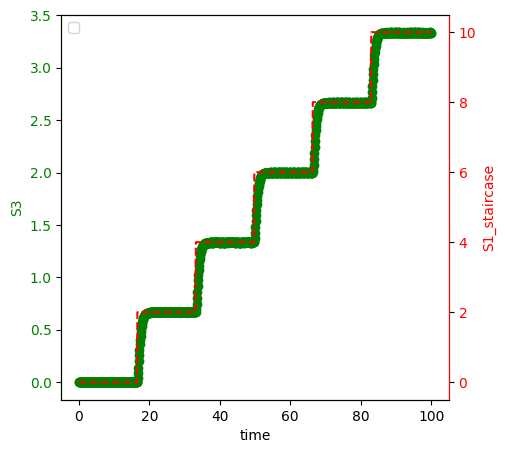

In [6]:
LINEAR_STAIRCASE = ctl.Staircase(initial_value=0, final_value=10, num_step=5)
response_ts = LINEAR_BLDR.makeStaircaseResponse(staircase=LINEAR_STAIRCASE, end_time=100)
_ = LINEAR_BLDR.plotStaircaseResponse(response_ts, figsize=(5,5))

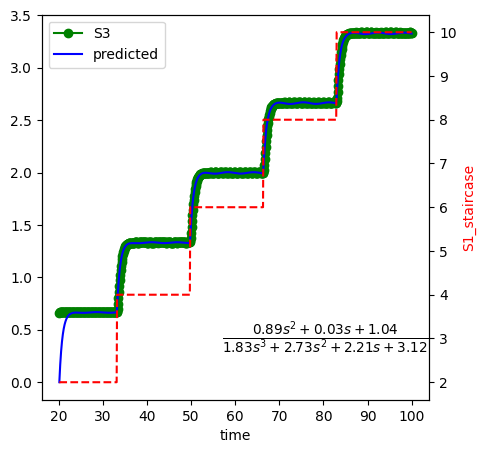

In [7]:
fitter_result = LINEAR_BLDR.fitTransferFunction(num_numerator=3, num_denominator=4, 
                                                      staircase=LINEAR_STAIRCASE, fit_start_time=20,
                                                start_time=0, end_time=100)
_ = LINEAR_BLDR.plotFitTransferFunction(fitter_result, figsize=(5,5))
LINEAR_TF = fitter_result.transfer_function

## Wolf Model

In [8]:
if False:
    WOLF_STAIRCASE = ctl.Staircase(initial_value=0, final_value=100, num_step=5)
    response_ts = WOLF_BLDR.makeStaircaseResponse(staircase=WOLF_STAIRCASE, end_time=100)
    WOLF_BLDR.plotStaircaseResponse(response_ts)

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [9]:
siso = ctl.SISOClosedLoopSystem(LINEAR_CTLSB)
siso.makePIDClosedLoopSystem(kp=0.5, ki=0.2, closed_loop_outputs=["S1", "S3"])

In [10]:
end_time =50
result_ts = siso.makeResponse(start_time=0, end_time=end_time, step_size=5)

Text(0, 0.5, 'S3')

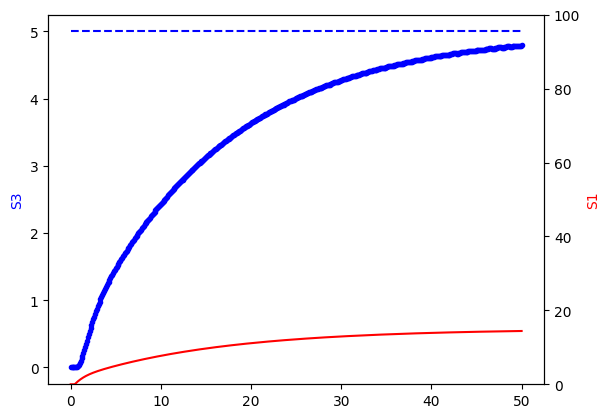

In [11]:
df = result_ts.copy()
times = np.array(df.index)/1000
plt.plot(times, df["S3"], color="blue", marker=".")
ax = plt.gca()
ax.plot(times, result_ts["reference"], linestyle="--", color = "blue")
ax2 = ax.twinx()
ax2.plot(times, result_ts["S1"], color="red")
ax2.set_ylim([0, 100])
ax2.set_ylabel("S1", color="red")
ax.set_ylabel("S3", color="blue")
#_ = ax.set_ylim([0, 5000])

# Closed Loop Design and Evaluation

In [12]:
LINEAR_TF.num, LINEAR_TF.den

([[array([0.88706735, 0.03058839, 1.03979509])]],
 [[array([1.83281194, 2.72845477, 2.21430005, 3.12407279])]])

In [13]:
designer = ctl.SISOClosedLoopDesigner(LINEAR_TF)

In [14]:
designer.design(ki=True, kp=True, kd=True)
designer.get()

{'kp': 172.84487505036682, 'ki': 52.77705067569055, 'kd': 1.0366302084791612}

In [15]:
designer.closed_loop_tf

TransferFunction(array([   9195.60807036, 1533567.53297665,  531817.27416183,
       1813376.17150968,  548773.18100287]), array([1.83281194e+00, 2.75264559e+04, 1.56085429e+06, 5.53963399e+05,
       1.84461690e+06, 5.48773181e+05]))

In [16]:
times = np.linspace(0, 20, 2000)
_, ys = control.forced_response(designer.closed_loop_tf, T=times, U=1, X0=0)
ys

array([0.        , 0.6153695 , 0.77577575, ..., 0.99998015, 0.99997912,
       0.99997809])

In [17]:
49.89/51.72

0.9646171693735499

In [18]:
s, kp, ki, kd, kf, tfsys, tfcl = sympy.symbols("s kp ki kd kf tfsys tfcl")
tfsys = (0.881*s**2 + 0.03059*s + 1.04)/(1.833*s**3 + 2.728*s**2 + 2.214*s + 3.124)
tfctl = kp + ki/s + kd*s
#tffltr = kf/(kf + s)
tffltr = 1
tffwd = tfsys*tfctl
tfloop = tffwd*tffltr
tfcl = tffwd/(1 + tfloop)
dct = {kp: 0, ki: 1, kd: 0, kf: 0}

In [19]:
sympy.simplify(tfcl.subs(dct))

(0.881*s**2 + 0.03059*s + 1.04)/(1.833*s**4 + 2.728*s**3 + 3.095*s**2 + 3.15459*s + 1.04)

In [20]:
designer.closed_loop_tf.poles()

array([-1.49617836e+04+0.j        , -5.65821046e+01+0.j        ,
       -1.71631978e-02+1.08255282j, -1.71631978e-02-1.08255282j,
       -3.01720740e-01+0.j        ])

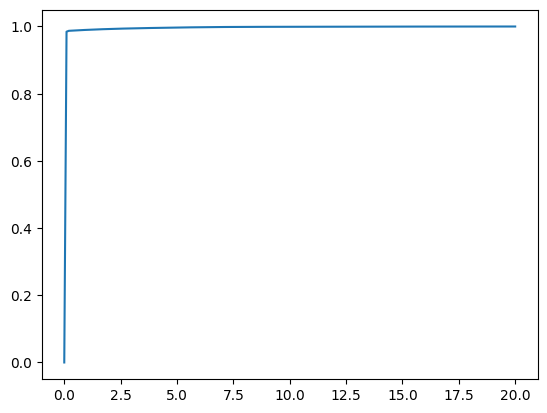

In [21]:
times = np.linspace(0, 20, 200)
_, ys = control.step_response(designer.closed_loop_tf, T=times)
plt.plot(times, ys)

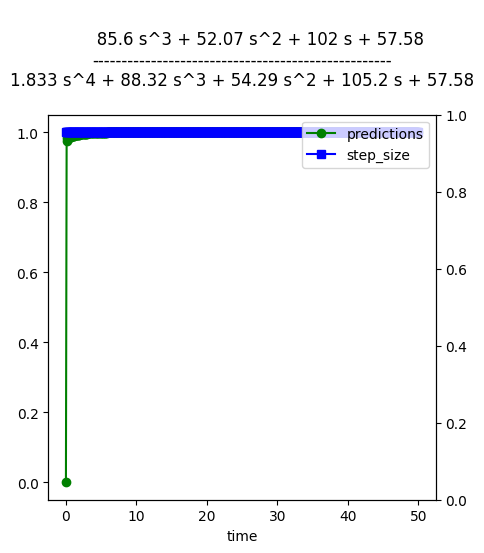

In [22]:
designer.design( kp=True, ki=True, kd=False)
times = np.linspace(0, 50, 500)
period = None
designer.plot(figsize=(5,5), times=times, period=period)  # Have options for a period

In [23]:
times = np.linspace(0, 2, 20)
dct = {"kp": 50, "ki": 1, "kd": 0.01}
designer.set(**dct)
designer.evaluateNonlinearIOSystemClosedLoop(LINEAR_CTLSB, times=times, is_fixed_input_species=True)

0.0 0.0 100.0
0.0 0.0 100.0
0.0 0.0 100.0
1e-06 0.0 100.0
1e-06 0.0 0.0
1e-06 0.0 0.0
1e-06 0.0 0.0
1.9999999999999998e-05 0.0 0.0
2.9999999999999997e-05 0.0 0.0
2.9999999999999997e-05 0.0 0.0
2.9999999999999997e-05 0.0 0.0
2.9999999999999997e-05 0.0 0.0
2.9999999999999997e-05 0.0 0.0
2.9999999999999997e-05 -9e-08 -1.46331883589177e-06
2.9999999999999997e-05 -9e-08 -2.508638227932538e-06
2.9999999999999997e-05 -9e-08 -3.2933685761303237e-06
2.9999999999999997e-05 -9e-08 -3.902546207531009e-06
2.9999999999999997e-05 -9e-08 -4.390452256058581e-06
2.9999999999999997e-05 -9e-08 -4.790354292553199e-06


RuntimeError: Algebraic loop detected.

In [ ]:
designer.siso.factory.loggers[8].report()

## Debug discrepancy between TF and Tellurium simulation

In [ ]:
linear_ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
linear_builder = linear_ctlsb.makeSISOTransferFunctionBuilder(is_fixed_input_species=True)
selections = ["[S%d]" % (n+1) for n in range(3)]
selections.insert(0, "time")
linear_ctlsb.roadrunner.reset()
linear_ctlsb.roadrunner["k0"] = 1
data = linear_ctlsb.roadrunner.simulate(0, 5, 50, selections=selections)
linear_ctlsb.roadrunner.plot()

In [ ]:
times = np.linspace(0, 5, 50)
_, ys = control.step_response(LINEAR_TF, T=times)
plt.plot(times, ys)
ax = plt.gca()
ax.set_ylim([0, 1])

In [ ]:
designer.set(kp=10)
times = [0, 20]
sys = designer.evaluateNonlinearIOSystemClosedLoop(LINEAR_CTLSB, times=times, is_fixed_input_species=True)

# Mix NonlinearIOSystem and Transfer Function

In [ ]:
sys = LINEAR_CTLSB.makeNonlinearIOSystem("system", input_names=["S1"], output_names=["S3"])

In [ ]:
control_tf = control.TransferFunction([1], [1, 1], inputs=["control_error"], outputs=["control_input"], name="controller")
control_ss = control.tf2ss(control_tf)

In [ ]:
forward_sys = control.series(sys, control_tf)
forward_sys.syslist

In [ ]:
closed_loop = control.feedback(forward_sys, 1)
closed_loop.ninputs, closed_loop.noutputs

In [ ]:
times = np.linspace(0, 20, 200)
_, ys = control.input_output_response(closed_loop, T=times, U=1)
plt.plot(times, ys)

In [ ]:
#control_tf = util.makePIDTransferFunction(kp = 1, ki=1, kd=10)
control_filter_tf = control_tf*control.TransferFunction([1000], [1, 1000])
control_filter_tf = control.TransferFunction([10000, 1000, 1000], [1, 1000, 0], name="controller", inputs="in", outputs="ot")
pass_tf = control.TransferFunction([1], [1, 1], name="pass", input="in", output="ot")
#control_tf = control.TransferFunction([1], [1, 1], inputs='i', outputs='u', name="controller")
control_ss = control.interconnect([control_filter_tf, pass_tf], inputs='controller.in', outputs='pass.ot',
                                 connections = [ ["pass.in", "controller.ot"]])

In [ ]:
kp, ki, kd, kf, s = sympy.symbols("k_p k_i k_d k_f s")
filter = sympy.simplify( kf/(s + kf)* ( kp + ki/s + s*kd))
filter

In [ ]:
control_tf = util.makePIDTransferFunction(kp = 1, ki=1, kd=10)*control.TransferFunction([1000], [1, 1000])
control_tf

In [ ]:
_, ys = control.step_response(control_ss, T=times)
ys

In [ ]:
times = np.linspace(0, 20, 200)

In [ ]:
loop_ss = control.interconnect([pass_tf, control_filter_tf, sys], inputs='controller.in', outputs='system.S3',
                                 connections = [ ["system.S1", "pass.ot"], ["pass.in", "controller.ot"]])